# ML in Cybersecurity: Task II

## Team
  * **Team name**:  Error 420 - Enhance Your Calm
  * **Members**:  Lennard Rixecker (s8lerixe@stud.uni-saarland.de), Jorim Bechtle (s8jmbech@stud.uni-saarland.de), Dominik Sautter (s8dksaut@stud.uni-saarland.de)


## Logistics
  * **Due date**: 25th Nov. 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Email the completed notebook to mlcysec_ws2022_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results.

Whenever possible, please use tools like tables or figures to compare the different findings


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
  ---

In [1]:
import time 
import timeit
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [3]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [4]:
#
#
# ------- Your Code -------
#
#

# 1. Attacking an ML-model (30 points) 

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data (4 Points)

Load the MNIST data, as done in task 1. 

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

In [5]:
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
epochs = 10

# (1)load data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

lastTest_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
lastTest_loader = DataLoader(dataset=lastTest_dataset, batch_size=batch_size, shuffle=True)

# (2)define model
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# (3)define loss, optimizer 
def newModel (numepoch):

    num_epochs = numepoch

    # Initialize network
    model = NN(input_size, num_classes)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    averageloss = 0
    counter = 0
    # Train Network
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.reshape(data.shape[0], -1)
            scores = model(data)
            loss = criterion(scores, targets)
            averageloss += loss
            counter += 1
            #print(f'averageloss: {averageloss}')

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
    return (model, float(averageloss/counter))

# (4)train (You can re-use the trained model from project1)
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    model.train()
    return (float(num_correct)/float(num_samples)*100)

losses = []
accuracytest = []
accuracytrain = []
runtime = []

(initialmodel, avgloss) = newModel(epochs)
losses.append(avgloss)
accuracytrain.append(check_accuracy(train_loader, initialmodel))
accuracytest.append(check_accuracy(test_loader, initialmodel))


train_acc = accuracytrain[-1]
epoch = epochs
test_acc = accuracytest[-1]


# (5)evaluate
print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_acc, test_acc))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Epoch 10, Train acc: 99.351667, Test acc: 97.630000


## 1.2: Implementing the FGSM attack (7 Points)

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example. 

Please implement the FGSM attack mentioned in the lecture. 

More details: https://arxiv.org/pdf/1412.6572.pdf


In [6]:
# implement fast gradient sign method for model above
def fgsm(model, x, y, epsilon):
    criterion = nn.CrossEntropyLoss()
    x = x.reshape(x.shape[0], -1)
    x.requires_grad = True
    scores = model(x)
    loss = criterion(scores, y)
    loss.backward()
    x_grad = x.grad.sign()
    x_adversarial = x + epsilon * x_grad
    x_adversarial = torch.clamp(x_adversarial, 0, 1)

    return x_adversarial.detach()


## 1.3: Adversarial sample set (7 Points)

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each. 
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set. 

In [7]:
epsilons = [0.1, 0.2, 0.3]

# generates 16 batches of 64 adv. images
def gen_1000_samples(model, epsilons):
    samples = [[] for _ in range(len(epsilons))]
    labels = []
    orig = []
    for i in range(16):
        x, y = next(iter(train_loader))
        for idx, e in enumerate(epsilons):
            x_ad = fgsm(model, x, y, e)
            samples[idx].append(x_ad)
        labels.append(y)
        orig.append(x)
    return orig, samples, labels

def get_predictions(model, samples):
    preds = []
    for i in range(len(samples)):
        x = samples[i]
        x = x.reshape(x.shape[0], -1)
        scores = model(x)
        _, predictions = scores.max(1)
        preds.append(predictions)
    return preds

def check_accuracy_from_xy(x, y, model):
    num_correct = 0
    num_samples = 0
    # model.eval()

    with torch.no_grad():
        assert len(x) == len(y)
        for i in range(len(x)):
            scores = model(x[i])
            _, predictions = scores.max(1)
            num_correct += (predictions == y[i]).sum()
            num_samples += predictions.size(0)
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100}')
    # model.train()
    return (float(num_correct)/float(num_samples)*100)

orig, samples, labels = gen_1000_samples(initialmodel, epsilons)

for i, e in enumerate(epsilons):
    print("Checking accuracy for epsilon=" + str(e))
    check_accuracy_from_xy(samples[i], labels, initialmodel)
    print("")


Checking accuracy for epsilon=0.1
Got 306 / 1024 with accuracy 29.8828125

Checking accuracy for epsilon=0.2
Got 76 / 1024 with accuracy 7.421875

Checking accuracy for epsilon=0.3
Got 29 / 1024 with accuracy 2.83203125



## 1.4: Visualizing the results (7 Points)

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created 

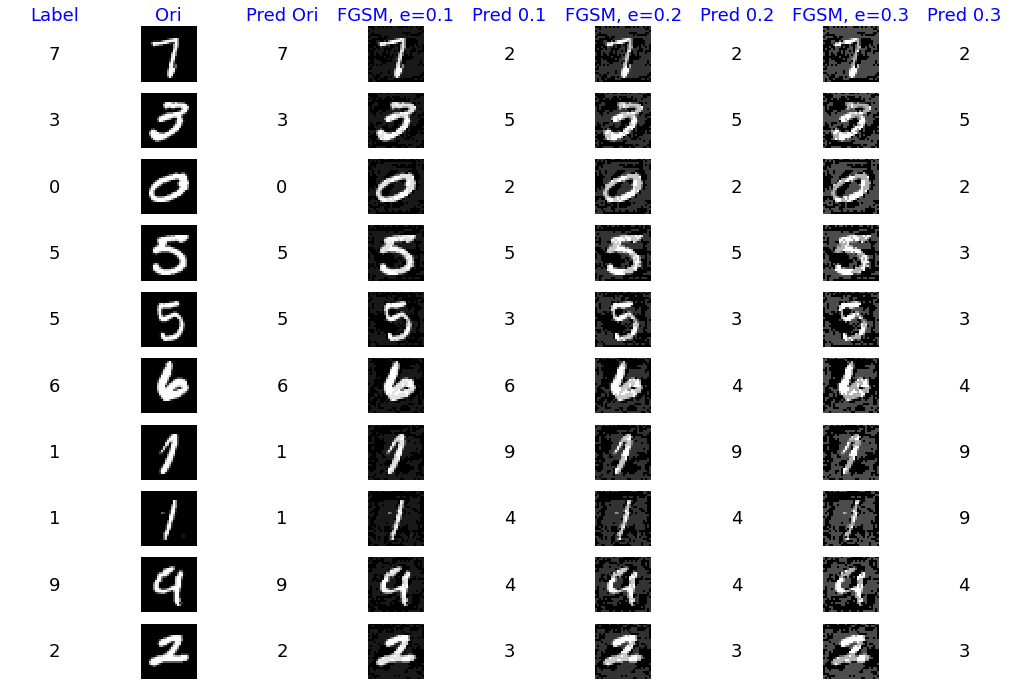

In [8]:
def showPics(model):
  # (each column corresponds to one attack method)
  col_titles = ['Label', 'Ori', 'Pred Ori', 'FGSM, e=0.1', 'Pred 0.1', 'FGSM, e=0.2', 'Pred 0.2', 'FGSM, e=0.3' ,'Pred 0.3']
  nsamples = 10
  nrows = nsamples
  ncols = len(col_titles)

  _, axes = plt.subplots(nrows,ncols,figsize=(18,12))  # create the figure with subplots
  [ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

  for ax, col in zip(axes[0], col_titles): # set up the title for each column
      ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

  preds_0 = get_predictions(model, orig)
  preds_1 = get_predictions(model, samples[0])
  preds_2 = get_predictions(model, samples[1])
  preds_3 = get_predictions(model, samples[2])
  for i in range(nsamples):
      axes[i,0].text(0.5, 0.5, int(labels[0][i]), fontsize=18, ha='center', va='center')
      axes[i,1].imshow(orig[0][i].reshape(28,28))
      axes[i,2].text(0.5, 0.5, int(preds_0[0][i]), fontsize=18, ha='center', va='center')
      axes[i,3].imshow(samples[0][0][i].reshape(28,28))
      axes[i,4].text(0.5, 0.5, int(preds_1[0][i]), fontsize=18, ha='center', va='center')
      axes[i,5].imshow(samples[1][0][i].reshape(28,28))
      axes[i,6].text(0.5, 0.5, int(preds_2[0][i]), fontsize=18, ha='center', va='center')
      axes[i,7].imshow(samples[2][0][i].reshape(28,28))
      axes[i,8].text(0.5, 0.5, int(preds_3[0][i]), fontsize=18, ha='center', va='center')

showPics(initialmodel)

## 1.5: Analyzing the results (5 Points)

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second) 
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations

Answers:
* The attack doesn't alway succed, but a higher pertubation budget results in a lower success rate; but even with a pertubationb budget of 0.1, the success rate is below 30%; when increasing the pertubation budget all the way to 0.3, the success rate drops down to 2.5%.
* The computation cost is really low, all 3000 samples are generated within 0.3 seconds
* The attack does need white box access to calculate the gradient

# 2. Defending an ML model (35 points) 

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


## 2.1: Implementing the adversarial training defense (20 Points)

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture. 

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples). 

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf 

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before. 

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


In [9]:
#
#
# ------- Your Code -------
#
#

losses = []
accuracytest = []
accuracytrain = []
runtime = []
models = []


start = timeit.default_timer()
print(f'ep{10} start')
(orgmodel, avgloss) = newModel(10)
models.append(orgmodel)
losses.append(avgloss)
accuracytrain.append(check_accuracy(train_loader, orgmodel))
accuracytest.append(check_accuracy(test_loader, orgmodel))
stop = timeit.default_timer()
runtime.append(stop-start)


print(f'[+] final Model done, with following stats: \nepochs {epochs}, \nlosses {losses}, \nacctrain {accuracytrain}, \nacctest {accuracytest}, \nruntime {runtime}')

###
#   implement the defence here
#   we get the dataset from the previous attack on our original model
#   using this dataset we train our new model, which should now be resistant to this type of attack
#   (only resistant to one specific epsilon, others are still vulnerable)
###

def newDefModel (numepoch):

    num_epochs = numepoch

    # Initialize network
    model = NN(input_size, num_classes)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    averageloss = 0
    counter = 0
    # Train Network
    for epoch in range(num_epochs):
        # Train Network with original data
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.reshape(data.shape[0], -1)
            scores = model(data)
            loss = criterion(scores, targets)
            averageloss += loss
            counter += 1

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        # Train Network with the altered samples
        for id_sample, data in enumerate(samples[1]):
            #print(f'for altered samples: {id_sample}')
            data = data.reshape(data.shape[0], -1)
            scores = model(data)
            loss = criterion(scores, labels[id_sample])
            averageloss += loss
            counter += 1

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

    #print(f'averageloss in total: {averageloss/counter}')
    return (model, float(averageloss/counter))

start = timeit.default_timer()
#print(f'start training new model')
(resultmodel, avgloss) = newDefModel(10)
models.append(resultmodel)
losses.append(avgloss)
accuracytrain.append(check_accuracy(train_loader, resultmodel))
accuracytest.append(check_accuracy(test_loader, resultmodel))
stop = timeit.default_timer()
runtime.append(stop-start)

print(f'[+] final Model done, with following stats \n   (org model / defending model): \nepochs {epochs}, \nlosses {losses}, \nacctrain {accuracytrain}, \nacctest {accuracytest}, \nruntime {runtime}')

ep10 start
[+] final Model done, with following stats: 
epochs 10, 
losses [0.06304939836263657], 
acctrain [99.43833333333333], 
acctest [97.71], 
runtime [120.69461338799994]
[+] final Model done, with following stats 
   (org model / defending model): 
epochs 10, 
losses [0.06304939836263657, 0.07034245878458023], 
acctrain [99.43833333333333, 99.01333333333334], 
acctest [97.71, 97.6], 
runtime [120.69461338799994, 118.52541875999998]


## 2.2: Evaluation (10 Points)

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM. 
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training. 
    * You can use two values of epsilons from question 1.3 
    
* Evaluate the **defended** model on these two adversarial examples sets. 


In [11]:
print(f'Accuracy original model:')
for i, e in enumerate(epsilons):
    print("Checking accuracy for epsilon=" + str(e))
    check_accuracy_from_xy(samples[i], labels, orgmodel)
    print("")

#print(f'Acuracy defended model:')
#for i, e in enumerate(epsilons):
#    print("Checking accuracy for epsilon=" + str(e))
#    check_accuracy_from_xy(samples[i], labels, resultmodel)
#    print("")


print(f'Checking accuracy for epsilon lower than the trained one:')
check_accuracy_from_xy(samples[0], labels, resultmodel)
print("")

print(f'Checking accuracy for epsilon that was used to train:')
check_accuracy_from_xy(samples[1], labels, resultmodel)
print("")

print(f'Checking acuracy for epsilon higher than the trained one:')
check_accuracy_from_xy(samples[2], labels, resultmodel)
print("")

Accuracy original model:
Checking accuracy for epsilon=0.1
Got 421 / 1024 with accuracy 41.11328125

Checking accuracy for epsilon=0.2
Got 125 / 1024 with accuracy 12.20703125

Checking accuracy for epsilon=0.3
Got 39 / 1024 with accuracy 3.80859375

Checking accuracy for epsilon lower than the trained one:
Got 1009 / 1024 with accuracy 98.53515625

Checking accuracy for epsilon that was used to train:
Got 1018 / 1024 with accuracy 99.4140625

Checking acuracy for epsilon higher than the trained one:
Got 948 / 1024 with accuracy 92.578125



## 2.3 Discussion (5 points)

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?

**Your answers go here**



*   The defended model has a higher succesrate in regards to the manipulated samples. With a higher epsilon, the successrate went lower. While for epsilon=0,1 the model still had a successrate of 41%, it went down to 3%. Looking at the defended model, which was trained with the samples of epsilon=0,2, the accuracy for all the tested epsilons went up. Not as much as for the sample version we trained the model with, but we still got 98 and 92% accuracy for epsilons=0,1 and 0,3.\
Less manipulated samples are also covered by a model trained with more manipulated samples. The more the samples are manipulated, the more they look like samples from the original data. Therefore it is easier to deceive the model, which results in a lower accuracy for a model trained with a less manipulated sample.
*   One set was created using epsilon=0,1 the others with 0,2 and 0,3.
The one we used to train the defended model, used epsilon=0,2. 



# 3: I-FGSM attack (35 points) 

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



## 3.1: Implementing the I-FGSM attack (10 Points)

**Hints**: 

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [ ]:
# budget: max eps?
# in paper there is a min of interation.
def ifgsm(model, x, y, eps, alpha, budget):
  #number_of_iteratives = int(min(eps + 4, 1.25 * eps))# from paper. in 3.2 seems not to be use 
  number_of_iteratives = int(budget / alpha)
  x_adv = x
  for i in range(number_of_iteratives):
    if inBudget(budget):
      budget -=alpha
      x_adv = fgsm(model, x_adv, y, alpha) # fgsm() is checking the allowed range
    else:
      return x_adv
  return x_adv

#  perturbation in budget
def inBudget(budget):
  if budget > 0:
    return True
  else:
    print('max budget is reached')
    return False     

## 3.2: Attack the undefended model (5 Points)

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

In [ ]:
# generates 16 batches of 64 adv. images
def gen_1000_samples_ifgsm(model, epsilons, alpha, budget):
    samples = []
    labels = []
    orig = []
    for i in range(16):
        x, y = next(iter(train_loader))
        x_ad = ifgsm(model, x, y, epsilons, alpha, budget)
        samples.append(x_ad)
        labels.append(y)
        orig.append(x)
    return orig, samples, labels

orig_ifgsm, samples_ifgsm, labels_ifgsm = gen_1000_samples_ifgsm(orgmodel, 2, 0.2, 0.2)

print(len(samples_ifgsm), len(labels_ifgsm))
print(len(samples[1]), len(labels))
standard_accuracy = check_accuracy_from_xy(samples[1], labels, orgmodel)
print(standard_accuracy)
accuracy_ifgsm = check_accuracy_from_xy(samples_ifgsm, labels_ifgsm, orgmodel)
print(accuracy_ifgsm)

16 16
16 16
Got 127 / 1024 with accuracy 12.40234375
12.40234375
Got 89 / 1024 with accuracy 8.69140625
8.69140625


### 3.2.1: Findings and comparison with FGSM (8 points)

* Please report your findings. How successful was the attack? 

* What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings) 

* Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?

* Feel free to report any interesting observations. 

**Your answers go here**

## 3.3: Attack the defended model (5 poinst) 

* In the previous question, we attacked the **undefended model**. 

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

16 16
Got 59 / 1024 with accuracy 5.76171875
5.76171875


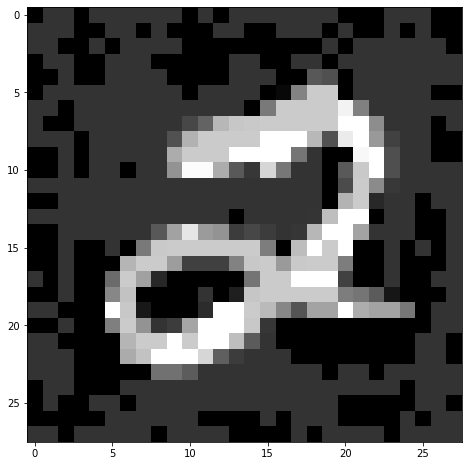

In [ ]:
orig, samples, labels = gen_1000_samples_ifgsm(resultmodel, 2, 0.2, 0.2)

print(len(samples), len(labels))
accuracy = check_accuracy_from_xy(samples, labels, resultmodel)
print(accuracy)
plt.imshow(samples[0][0].reshape(28,28))
plt.show()

### 3.3.1: Discussion (7 points) 
* Please report your results. How successful was the attack on the defended model? 
* Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference? 
* How do you think you can improve the defense against I-FGSM attack?


* Feel free to state any interesting findings you encountered during this project.

**Your answers go here**